In [4]:
!pip install scikit-image
!pip install opencv-python
!pip install trans

You should consider upgrading via the 'd:\deepllearning\price_detection_deep_learning\env\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\deepllearning\price_detection_deep_learning\env\scripts\python.exe -m pip install --upgrade pip' command.


  Using cached trans-2.1.0-py3-none-any.whl


You should consider upgrading via the 'd:\deepllearning\price_detection_deep_learning\env\scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip3 install torch==1.10.0 torchvision==0.11.1

  Using cached torch-1.10.0-cp38-cp38-win_amd64.whl (226.6 MB)
  Using cached torchvision-0.11.1-cp38-cp38-win_amd64.whl (984 kB)


You should consider upgrading via the 'd:\deepllearning\price_detection_deep_learning\env\scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from skimage.transform import resize
from skimage import util
import logging
import os
import sys
from random import choice
import cv2
import matplotlib.pyplot as plt
from class_cnnnet import CNNNet
import torch
from torchvision import datasets, transforms

sys.path.append(os.path.abspath(".."))
from src.data.price_locations import PriceLocationsDataset
from src.display.display_image import display_annotations, display_image
#from src.models.digit_detector import DigitDetector
#from src.processing.croping import crop_image
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device = cpu


In [8]:
model = CNNNet()
model.load_state_dict(torch.load('model_cnn.pth'))

<All keys matched successfully>

In [9]:
dataset = PriceLocationsDataset() #dataset est une instanse d'une classe et PriceLocationsDataset est une classe

INFO:root:The price location dataset is now loaded (18 elements)


Fonction qui pour une image, affiche une étiquettes et l'image croppée

Fonction qui pour une étiquette, affiche toutes ses box

Fonction qui pour une box, affiche tous ses chiffres

In [24]:
#Fonction qui pour une image, affiche une étiquettes et l'image croppée

#img_name = '0002.jpg'

def tags(img_name, tag_number):
    image = dataset.get_original_image(img_name)
    tags = dataset.get_all_annotations_for_one_image(img_name)
    print(tags)
    number_of_tag = len(tags)
    print(number_of_tag)
    tag = tags.iloc[tag_number%number_of_tag]
    cropped_img = image[int(tag.y1):int(tag.y2), int(tag.x1):int(tag.x2)]
    return(cropped_img)

In [11]:
#dataframe de contours de chaque chiffre d'un tag
def numbers_contours(contours, precision) :
    rect_list = []
    rect_dico = {}
    x = precision
    for contour in contours: 
         rect = cv2.minAreaRect(contour)
         box = cv2.boxPoints(rect)
         rect_list.append(
         {"x1": box[0][0] - x,
         "y1" : box[0][1] - x,
         "x2" : box[2][0] + x,
         "y2" : box[2][1] + x
         }
         )
    tag_contours = pd.DataFrame.from_records(rect_list) # dataframe avec x1, x2, y1, y2
    tag_contours_without_neg_values = tag_contours[(tag_contours > 0).all(axis=1) & (tag_contours.x2 - tag_contours.x1 > 1) & (tag_contours.y2 - tag_contours.y1 > 1)]
    return(tag_contours_without_neg_values)

#Pour chaque tag, retourne une liste d'image de chaque chiffre du tag 
def boxes(cropped_img):
    box_list = []
    img_black_and_white = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    img_invert_color = cv2.bitwise_not(img_black_and_white)
    ret, thresh = cv2.threshold(img_invert_color, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    nb_contours = numbers_contours(contours, 2)
    for i in range(len(nb_contours)):
        digit = nb_contours.iloc[i]
        cropped_tag = cropped_img[int(digit.y1):int(digit.y2), int(digit.x1):int(digit.x2)]
        box_list.append(cropped_tag)
    return(box_list)

In [12]:
def transform_box(box_img):
    trans = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize( (0.1307,),(0.3081,))])
    img_resize = resize(box_img, (28, 28))
    img_resize = util.invert(img_resize)
    img_tensor = trans(img_resize[:,:])
    img_tensor = img_tensor.float()
    img_tensor = img_tensor.mean(axis=0)
    img_tensor = img_tensor.unsqueeze(0)
    return(img_tensor)

In [13]:
def prediction(image, tag_number):
    cropped_img = tags(image, tag_number)
    box_list = boxes(cropped_img)
    number_of_boxes = len(box_list)
    fig,axes = plt.subplots(number_of_boxes,1,figsize=(15,15))
    for i in range(number_of_boxes):
        box_img = box_list[i]
        box_img_transformed = transform_box(box_img)
        print(box_img_transformed.shape)
        prediction_tensor = model(box_img_transformed.unsqueeze(0))
        pred = prediction_tensor.argmax()
        axes[i].imshow(box_img_transformed.squeeze(0), cmap = 'gray')
        axes[i].set_title('MNIST prediction ({})'.format(pred))

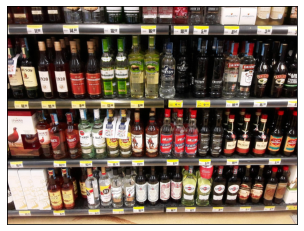

In [22]:
image ='0002.jpg'
tag_id = 5
display_image(plt.imread('../data/train/images/' + image))

                                             img_name           x1  \
35  D:\DeeplLearning\price_detection_deep_learning...   176.681818   
36  D:\DeeplLearning\price_detection_deep_learning...   500.772727   
37  D:\DeeplLearning\price_detection_deep_learning...   862.500000   
38  D:\DeeplLearning\price_detection_deep_learning...  1186.590909   
39  D:\DeeplLearning\price_detection_deep_learning...  1487.681818   
40  D:\DeeplLearning\price_detection_deep_learning...  1654.954545   
41  D:\DeeplLearning\price_detection_deep_learning...  1930.954545   
42  D:\DeeplLearning\price_detection_deep_learning...  2225.772727   
43  D:\DeeplLearning\price_detection_deep_learning...  1945.590909   
44  D:\DeeplLearning\price_detection_deep_learning...  2186.045455   
45  D:\DeeplLearning\price_detection_deep_learning...  1686.318182   
46  D:\DeeplLearning\price_detection_deep_learning...  1435.409091   
47  D:\DeeplLearning\price_detection_deep_learning...  1094.590909   
48  D:\DeeplLearning

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


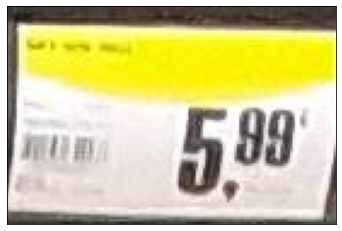

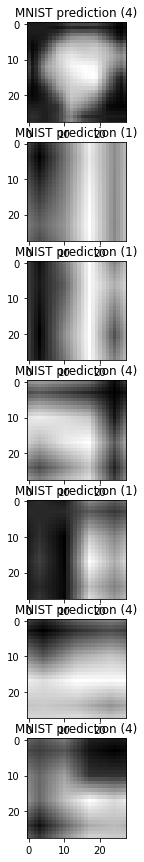

In [25]:
display_image(tags(image, tag_id))
prediction(image, tag_id)
